# Вплив Налаштувань si5351c тa Міксерів на Рівень Фазових Шумів та Спурів FobosSDR

## Передумови

- **FobosSDR rev.2 (фільтр та обв'язка FX3 виправлені)**;
- модифікований драйвер https://github.com/fobos777/libfobos (заснований на офіційній версії v2.3.1); зібраний з
  ```c
  static const bool CALIBRATION_DEBUG_GAINS = true;
  static const bool CALIBRATION_DEBUG_SIGNAL = true;
  ```
- термінатори на обох HF входах;
- FM bandstop фільтр перед RF входом;
- SDRAngel v7.22.6-8;
- **max2830 налаштований на `2350 МГц`, rffc5072 - на `2352 МГц`**;
- **рівень підсилення LNA середній, VGA - 0 dB**;
- **преселектор вимкнений**;
- **50MSps; 32K FFT; вікно: Hann; тип усереднення: Fix; кількість усереднених спектрів: 500**.

## si5351c

### Залежність від частоти VCO

#### Данні

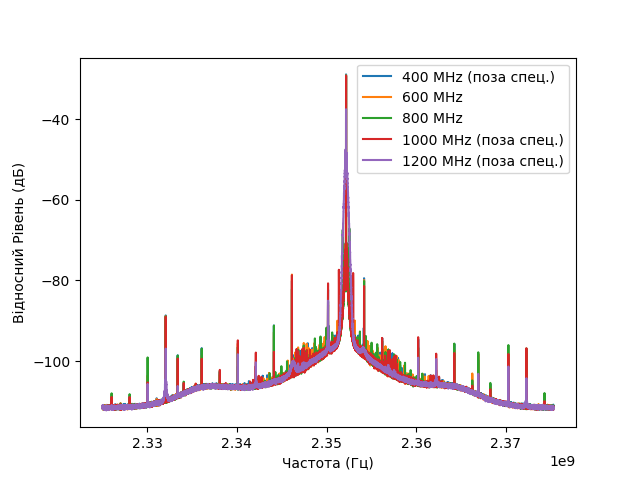

In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib widget

plt.figure()

dataset = {}

dataset["400 MHz (поза спец.)"] = "./phase_noise/si5351c_400MHz_LNA1_VGA0_FREF40MHz.csv"
dataset["600 MHz"] = "./phase_noise/si5351c_600MHz_LNA1_VGA0_FREF40MHz.csv"
dataset["800 MHz"] = "./phase_noise/si5351c_800MHz_LNA1_VGA0_FREF40MHz.csv"
dataset["1000 MHz (поза спец.)"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF40MHz.csv"
dataset["1200 MHz (поза спец.)"] = "./phase_noise/si5351c_1200MHz_LNA1_VGA0_FREF40MHz.csv"

for name, filename in dataset.items():
    data = read_csv(filename)
    freq = data["Frequency"] - 650e6
    power = data["Power"]
    plt.plot(freq, power,label=name)

plt.ylabel("Відносний Рівень (дБ)")
plt.xlabel("Частота (Гц)")
plt.legend()

#### Висновок

- рівень фазових шумів падає з частотою VCO si5351c до 1000 МГц, а потім суттєво зростає для 1200 МГц, що не є неочікуваним, бо цей режим далеко за межами робочого для si5351c;
- для 1000 МГц, дільник VCO не парний для утворення опорної частоти у 40 МГц для міксерів, що може бути додатковим джерелом фазового шуму.

### Залежність від парності дільника VCO для утворення опорних частот міксерів

При утворенні частоти у $`f_{REF} =40 МГц`$ для $`f_{VCO} = 800 МГц`$ використовується парний дільник 20, а для $`f_{VCO} = 1000 МГц`$ - не парний 25. Відповідно до специфікації `si5351c`, непарні дільники призводять до збільшення фазового шуму. Якщо збільшити $`f_{REF}`$ до 50 МГц, то для обох значень частоти VCO будуть використовуватися парні дільники, 16 та 20, відповідно. Це дозволить більш коректно порівняти зміну картини фазових шумів при переході від $`f_{VCO} = 800 МГц`$ до $`f_{VCO} = 1000 МГц`$.

#### Данні

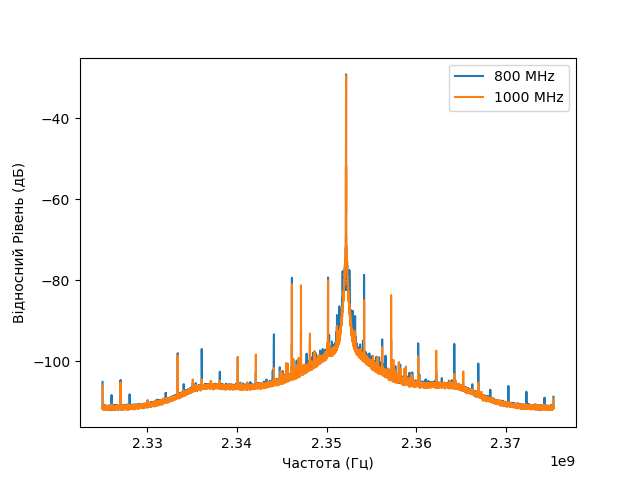

In [5]:
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib widget

plt.figure()

dataset = {}

dataset["800 MHz"] = "./phase_noise/si5351c_800MHz_LNA1_VGA0_FREF50MHz.csv"
dataset["1000 MHz"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz.csv"

for name, filename in dataset.items():
    data = read_csv(filename)
    freq = data["Frequency"] - 650e6
    power = data["Power"]
    plt.plot(freq, power,label=name)

plt.ylabel("Відносний Рівень (дБ)")
plt.xlabel("Частота (Гц)")

plt.legend()

#### Висновок

- за рівних умов, $`f_{VCO} = 1000 МГц`$ демонструє менший рівень фазового шуму та спурів, порівняно з $`f_{VCO} = 800 МГц`$.

## max2830

### Вплив режиму PLL

PLL `max2830` може працювати в цілому чи дробовому режимах (за замовчуванням). Так як FobosSDR використовує значення ПЧ 2350 МГц та 2450 МГц, які при значеннях опорної у $`f_{REF} = 50 МГц`$ можуть бути отримані за допомогою цілих дільників, 47 та 49, відповідно, то існує можливість використання PLL `max2830` у цілому режимі (біт 10 нульового регистру встановлено у 0).

#### Даннi

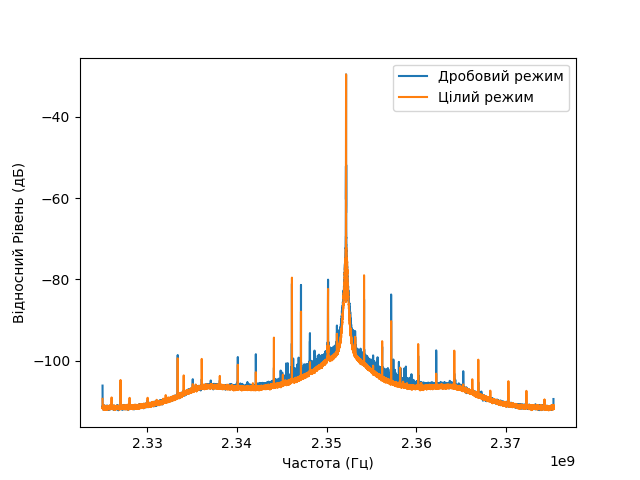

In [3]:
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib widget

plt.figure()

dataset = {}

dataset["Дробовий режим"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz.csv"
dataset["Цілий режим"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL.csv"

for name, filename in dataset.items():
    data = read_csv(filename)
    freq = data["Frequency"] - 650e6
    power = data["Power"]
    plt.plot(freq, power,label=name)

plt.ylabel("Відносний Рівень (дБ)")
plt.xlabel("Частота (Гц)")

plt.legend()

#### Висновок

- використання PLL `max2830` в цілочисельному режимі призводить до суттєвого зменшення високочастотних складових фазового шуму.

## Порівннянна стокових та оптимізованих налаштувань

- **Сток**: \
  $`f_{VCO} = 800 МГц`$ \
  $`f_{REF} = 40 МГц`$ \
  Дробовий режим PLL max2830

- **Оптимізований**: \
  $`f_{VCO} = 1000 МГц`$ \
  $`f_{REF} = 50 МГц`$ \
  Цілочисельний режим PLL max2830
  

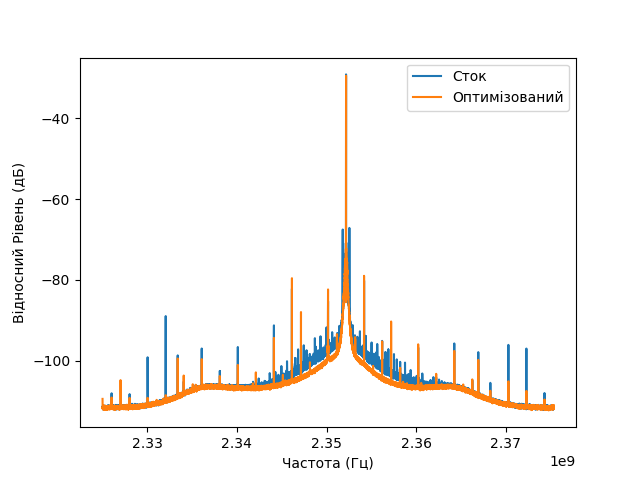

In [4]:
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib widget

plt.figure()

dataset = {}

dataset["Сток"] = "./phase_noise/si5351c_800MHz_LNA1_VGA0_FREF40MHz.csv"
dataset["Оптимізований"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL.csv"

for name, filename in dataset.items():
    data = read_csv(filename)
    freq = data["Frequency"] - 650e6
    power = data["Power"]
    plt.plot(freq, power,label=name)

plt.ylabel("Відносний Рівень (дБ)")
plt.xlabel("Частота (Гц)")

plt.legend()

## Вплив USB3 кабеля

Порівнюються наступні USB3 кабелі

- стоковий FobosSDR
- [StarTech USB3CAB1M](https://www.startech.com/en-eu/cables/usb3cab1m)
- [Eaton Tripp Lite U422-003-G2](https://tripplite.eaton.com/usb-3-1-gen-2-10-gbps-cable-usb-type-c-usb-c-usb-3-0-type-b-male-male-3-ft~U422003G2)

а також вплив USB3 EMI фільтру [Würth Elektronik Filter Stick USB 3.1 Type C 100W EMC](https://www.we-online.com/en/components/products/EMC_FILTER_BAGS_STICKS_USB_3_1_TYPE_C_100W_EMV_FILTERSTICK)

**Для цього тесту max2830 налаштований на `2450 МГц`, rffc5072 - на `2455 МГц`, a кількість усереднених спектрів зменшена до 100.**

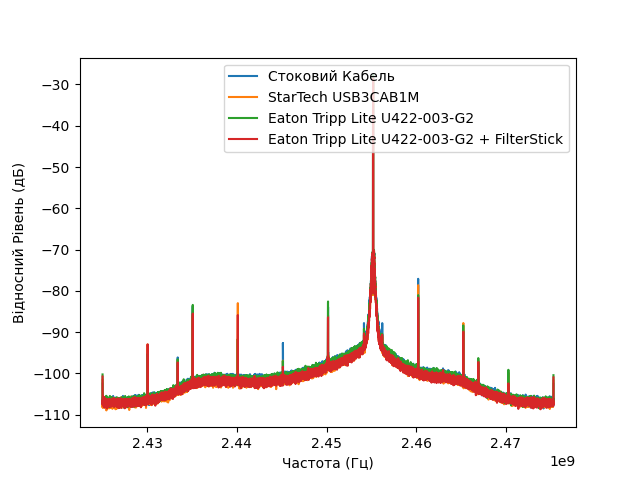

In [11]:
from pandas import read_csv
import matplotlib.pyplot as plt

%matplotlib widget

plt.figure()

dataset = {}

dataset["Стоковий Кабель"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL_RFFC5072OPT_CableFobosSDRStock_NoFilterStick.csv"
dataset["StarTech USB3CAB1M"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL_RFFC5072OPT_CableStarTechUSB3CAB1M_NoFilterStick.csv"
dataset["Eaton Tripp Lite U422-003-G2"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL_RFFC5072OPT_CableEatonU422-003-G2_NoFilterStick.csv"
dataset["Eaton Tripp Lite U422-003-G2 + FilterStick"] = "./phase_noise/si5351c_1000MHz_LNA1_VGA0_FREF50MHz_MAX2830INTPLL_RFFC5072OPT_CableEatonU422-003-G2_FilterStick.csv"

for name, filename in dataset.items():
    data = read_csv(filename)
    freq = data["Frequency"] - 550e6
    power = data["Power"]
    plt.plot(freq, power,label=name)

plt.ylabel("Відносний Рівень (дБ)")
plt.xlabel("Частота (Гц)")

plt.legend()